In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.datasets import mnist

In [ ]:
(train_images, train_labels), (_, _) = mnist.load_data()

train_images_standard = train_images.reshape((60000, 28, 28, 1))
train_images_standard = train_images_standard.astype('float32') / 255

print(train_images.shape)
print(train_images_standard.shape)

(60000, 28, 28)
(60000, 28, 28, 1)


In [ ]:
def visualize_batch(data, batch_size, imgs_per_row):
  f, plots = plt.subplots((batch_size+imgs_per_row-1)//imgs_per_row, imgs_per_row, figsize=(10,10))
  plots = [plot for sublist in plots for plot in sublist]

  for img, plot in zip(data, plots):
      plot.imshow(img, cmap='gray')

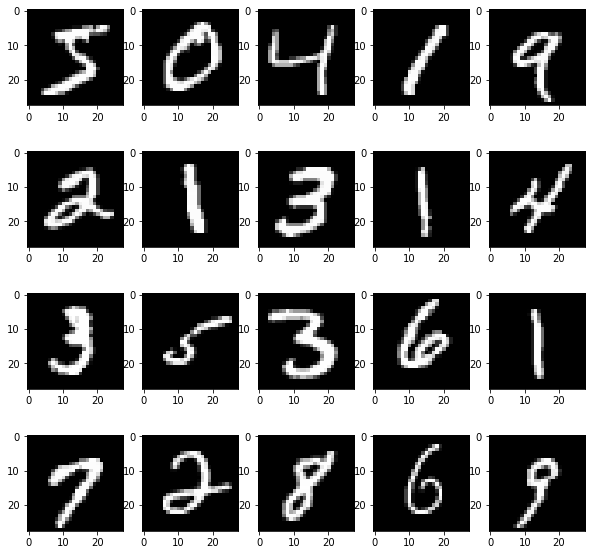

In [ ]:
visualize_batch(train_images[:20], 20, 5)

In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
  # choose random instances
  ix = np.random.randint(0, dataset.shape[0], n_samples)
  # retrieve selected images
  X = dataset[ix]
  # generate 'real' class labels (1)
  y = np.ones((n_samples, 1))
  return X, y

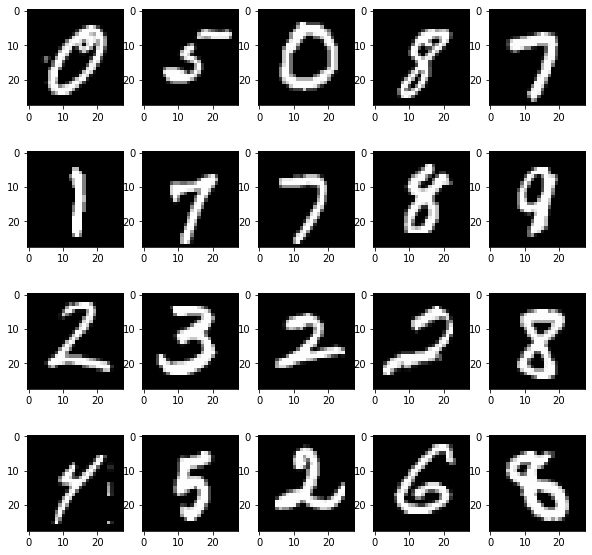

In [ ]:
test_images, test_labels = generate_real_samples(train_images_standard, 20)
test_images = test_images.reshape(20, 28, 28)
visualize_batch(test_images, 20, 5)

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [ ]:
# define the standalone discriminator
def define_discriminator(input_shape=(28, 28, 1)):
  model = models.Sequential()
  model.add(layers.Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.4))
  model.add(layers.Conv2D(64, (3,3), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.4))
  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])

  return model

In [ ]:
def define_generator(latent_dim):
  model = models.Sequential()

  # foundation for 7x7 image
  n_nodes = 128 * 7 * 7
  model.add(layers.Dense(n_nodes, input_dim=latent_dim))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Reshape((7, 7, 128)))

  # upsample to 14x14
  model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))

  # upsample to 28x28
  model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Conv2D(1, (7,7), activation='sigmoid', padding='same'))

  return model

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = np.zeros((n_samples, 1))
	return X, y

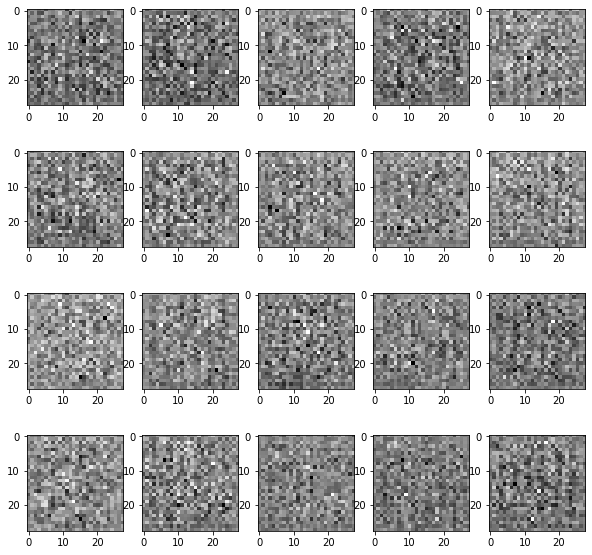

In [ ]:
test_images, test_labels = generate_fake_samples(define_generator(100), 100, 20)
test_images = test_images.reshape(20, 28, 28)
visualize_batch(test_images, 20, 5)

In [ ]:
def define_gan(g_model, d_model):

  d_model.trainable = False

  gan_model = models.Sequential()
  # add generator
  gan_model.add(g_model)
  # add the discriminator
  gan_model.add(d_model)

  gan_model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002, beta_1=0.5))

  return gan_model

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected 'real' samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
      # generate 'fake' examples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)

      # create training set for the discriminator
      X = np.vstack((X_real, X_fake))
      y = np.vstack((y_real, y_fake))

      # update discriminator model weights
      d_loss, _ = d_model.train_on_batch(X, y)
      # prepare points in latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = np.ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      # summarize loss on this batch
      print(f'Epoch: {i}, {j}, d={d_loss:.3}, g={g_loss:.3}')

In [ ]:
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(100)
# create the gan
gan_model = define_gan(g_model, d_model)

train(g_model, d_model, gan_model, train_images_standard, 100)

Epoch: 0, 0, d=0.692, g=0.706
Epoch: 0, 1, d=0.689, g=0.725
Epoch: 0, 2, d=0.681, g=0.74
Epoch: 0, 3, d=0.67, g=0.755
Epoch: 0, 4, d=0.669, g=0.774


KeyboardInterrupt: ignored